In [1]:
# !pip install numpy-financial
# !pip install ipytest

In [2]:
from dataclasses import dataclass

import numpy as np
import numpy_financial as npf
import pandas as pd

from scipy.optimize import minimize, minimize_scalar
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)

from IPython.display import display, HTML

import ipytest
import pytest
ipytest.autoconfig()

def P(txt):
    display(HTML(txt))

# Investment Calculator

Scenario: I have the option of buying a Photovoltaic System today for 20000 EUR.
I expect this investment to bring a annual return of 1250 EUR in reductions to my power bill,
and gains from selling electricity. The expected lifetime this system is 30 years.

Question:
- Is this investment worth making?
- How much of my own money should I invest, how much should I cover with a credit?

We solve this problem more generally.

In [3]:
PRESENT_VALUE  = 20000 # total costs of payment
ANNUAL_PAYMENT = 1250  # payment per year
PERIODS        = 30    # number of periods "years"

# Naive Profit

After 30 years, we have generated 1250 x 30 of savings, substracting the 20K we have returned a naive profit of:

In [4]:
N_PROFIT = ANNUAL_PAYMENT * PERIODS - PRESENT_VALUE

print(f"Naive Profit: {N_PROFIT} EUR")

Naive Profit: 17500 EUR


So it looks like, we are turning a profit!

How much interest do we get on our investment each year?

Every year we are generating 1250 EUR of earnings, for the 20000 EUR we have put in.
Also at the end of the 30 years, we will have lost our total investment. Averaged we are loosing 20000 / 30.
Combining both numbers we get a naive return of investment:

In [5]:
N_RATE = (ANNUAL_PAYMENT - PRESENT_VALUE / PERIODS) /  PRESENT_VALUE

print(f"Naive RATE = {N_RATE * 100 :.2f} %" )

Naive RATE = 2.92 %


So we are earning an interest of 2.9% every year. 

We are getting the same number from the Naive Profit as N_PROFIT / PERIODS / PRESENT_VALUE

In [6]:
N_RATE * PRESENT_VALUE * PERIODS # = N_PROFIT

17500.0

Caveat: Ff we had 20000 and would invest it at 2.92% interest rate, we would earn MUCH more than N_PROFIT due to effects of compound interest:

In [7]:
PRESENT_VALUE * np.power((1+N_RATE), PERIODS)

47380.685754793194

# Cash Flow Analysis

We are trading two different cash flows for each other, and want to know which one has a higher value for us right now.
We represent cash flows as arrays of numbers representing annual payments.
We determine present value, by discounting future values with an interest rate.

In [8]:
class CashFlow(pd.Series):
   
    @classmethod
    def from_constant(cls, years, value):
        return cls(np.zeros(years + 1) + value)

    @classmethod
    def from_investment(cls, N, PV, PMT):
        cf = np.zeros(N + 1)
        cf[0] = -PV
        cf[1:] += PMT
        return cls(cf, name="Cash Flow")
    
    def pad(self, years):
        return CashFlow(self.copy().reindex(range(years+1), fill_value = 0))

    def plot(self, **kwargs):
        if not "kind" in kwargs:
            kwargs["kind"] = "bar"
        super().plot(**kwargs)
        plt.title("Cash Flow Plot")
        plt.ylabel("Cash Flow/EUR")
        plt.xlabel("Year")
        plt.axhline(y=0, color='k', linewidth=0.5)

    def discount(self, interest_rate):
        discount_factor = 1 / (1 + interest_rate) ** np.arange(len(self))
        return CashFlow( self * discount_factor )

    def present_value(self, interest_rate):
        return npf.npv(interest_rate, self)
    
    def neg(self):
        o = self.copy()
        o[ o > 0 ] = 0
        return CashFlow(o)
    
    def pos(self):
        o = self.copy()
        o[ o < 0 ] = 0
        return CashFlow(o)
    
    def __add__(cf1, cf2):
        l = max(len(cf1), len(cf2))
        return CashFlow( np.array(cf1.pad(l)) + np.array(cf2.pad(l)) )

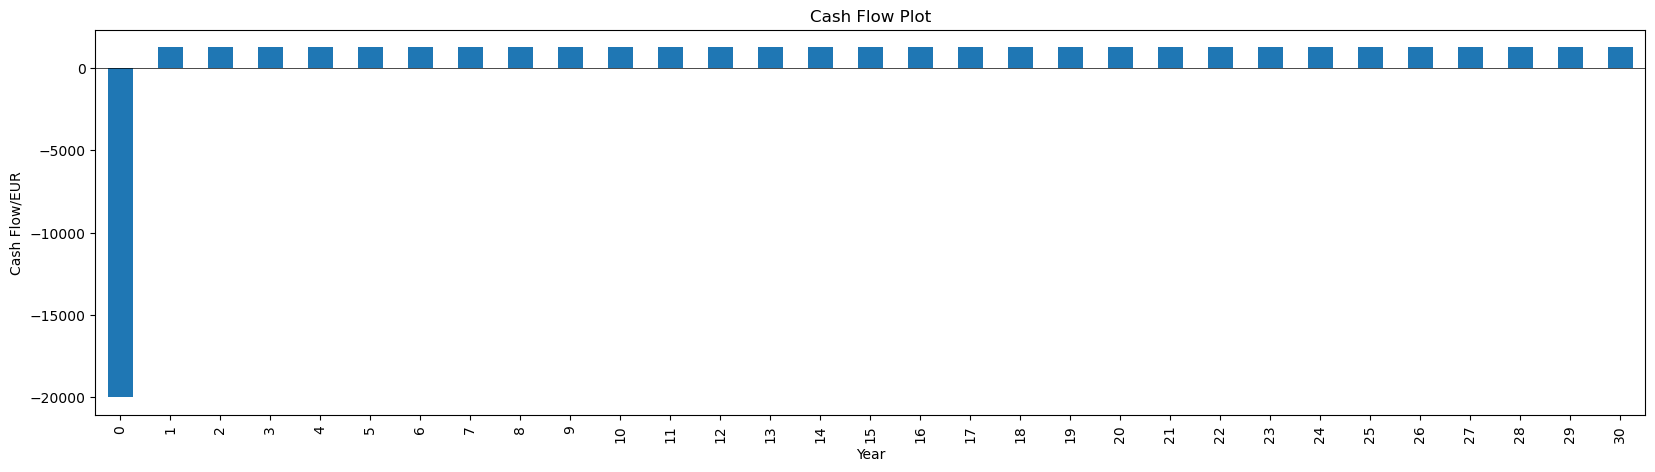

In [9]:
CF = CashFlow.from_investment(PERIODS, PRESENT_VALUE, ANNUAL_PAYMENT) 
CF.plot()

With a zero interest rate, we are getting back the naive profit as prevent value:

In [10]:
CF.sum()

17500.0

In [11]:
CF.present_value(0)

17500.0

In [12]:
N_PROFIT

17500

With a greater interest rate, the future income get's less valuable:

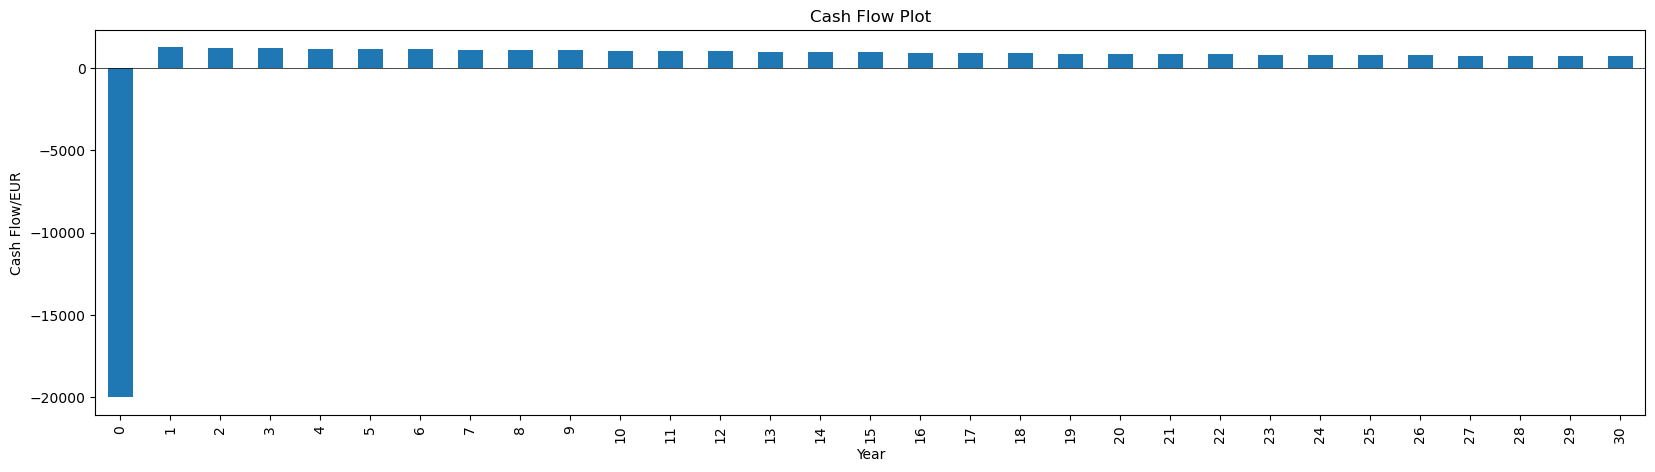

In [13]:
INFLATION = 0.02
CF.discount(INFLATION).plot()

It turns out that with this interest rate, the sum of the cash flow get's negative:

In [14]:
%%ipytest
def test_discount():
    assert CF.discount(0.05).sum() == CF.present_value(0.05)
    assert CF.discount(0).sum() == CF.sum()
    assert CF.present_value(0) == CF.sum()

.                                                                                            [100%]
1 passed in 0.01s


In [15]:
CF.discount(-0.01).sum()

23987.34203340131

In [16]:
CF.present_value(-0.01)

23987.34203340131

## At which interest rates has the a Cash Flow positive present value?

In our example, we had a positive present value of ~17K at zero interest.
With 5% interest we had a negative present value.
What is the maximal interest rate we can pay without loosing money?

In [17]:
from scipy.optimize import root_scalar

def cash_flow_solve_discount_interest(cf):
    res = root_scalar(lambda x: cf.present_value(x), bracket=[0,1])
    if res.converged:
        return res.root
    else:
        raise None

In [18]:
r = cash_flow_solve_discount_interest(CF)
print(f"Limit discount rate = {r*100:.3f}%")

Limit discount rate = 4.653%


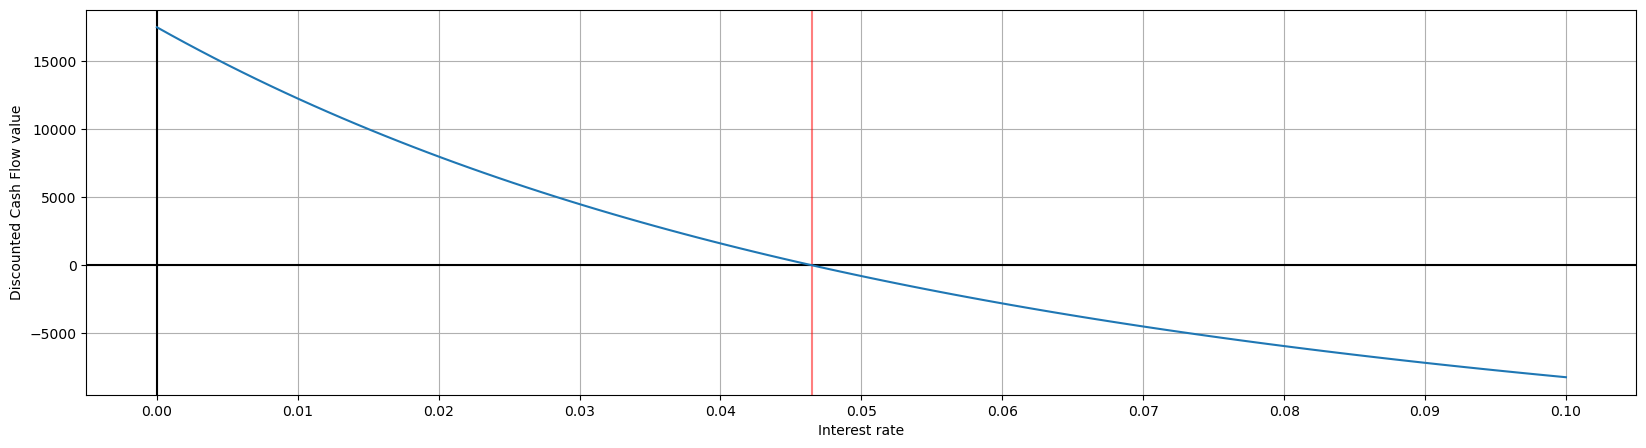

In [19]:
MAX_INTEREST = 0.1
plt.figure(figsize=(20,5))
X = np.linspace(0,MAX_INTEREST,100)
Y = [ CashFlow.from_investment(PERIODS, PRESENT_VALUE, ANNUAL_PAYMENT).present_value(x) for x in X]
plt.xlabel("Interest rate")
plt.ylabel("Discounted Cash Flow value")
plt.grid(True)
plt.xticks(np.linspace(0,MAX_INTEREST,11))
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.axvline(x=r, color='r', alpha=0.5)
plt.plot(X, Y);

# Value Series - Track the value of an asset over time

In [39]:
class ValueSeries(pd.Series):
    "Represents the value of an asset over time."
    
    @classmethod
    def from_deposit(cls, years, amount):
        return cls(np.zeros(years + 1) + amount, name="Value Series")
    
    @classmethod
    def from_cash_flow(cls, cf : CashFlow):
        return cls(np.cumsum(cf), name="Value Series")
    
    def with_interest(self, interest_rate):
        out = ValueSeries(self.copy())
        for i in range(1, len(out)):
            out[i:] += out[i-1] * interest_rate
        return out
       
    def discount(self, interest_rate):
        discount_factor = 1 / (1 + interest_rate) ** np.arange(len(self))
        return ValueSeries(self * discount_factor)
        
    def cash_flow(self):
        return CashFlow(self.diff())
    
    def total(self):
        return self.iloc[-1]
    
    def plot(self, **kwargs):
        if not "kind" in kwargs:
            kwargs["kind"] = "bar"
        super().plot(**kwargs)
        plt.ylabel("EUR")
        plt.xlabel("Year")
        plt.axhline(y=0, color='k', linewidth=0.5)
        plt.ylabel("Accumulated Value")
        plt.title("Accumulated Value Plot")

## A deposited amount keeps constant value (in today's EURs)

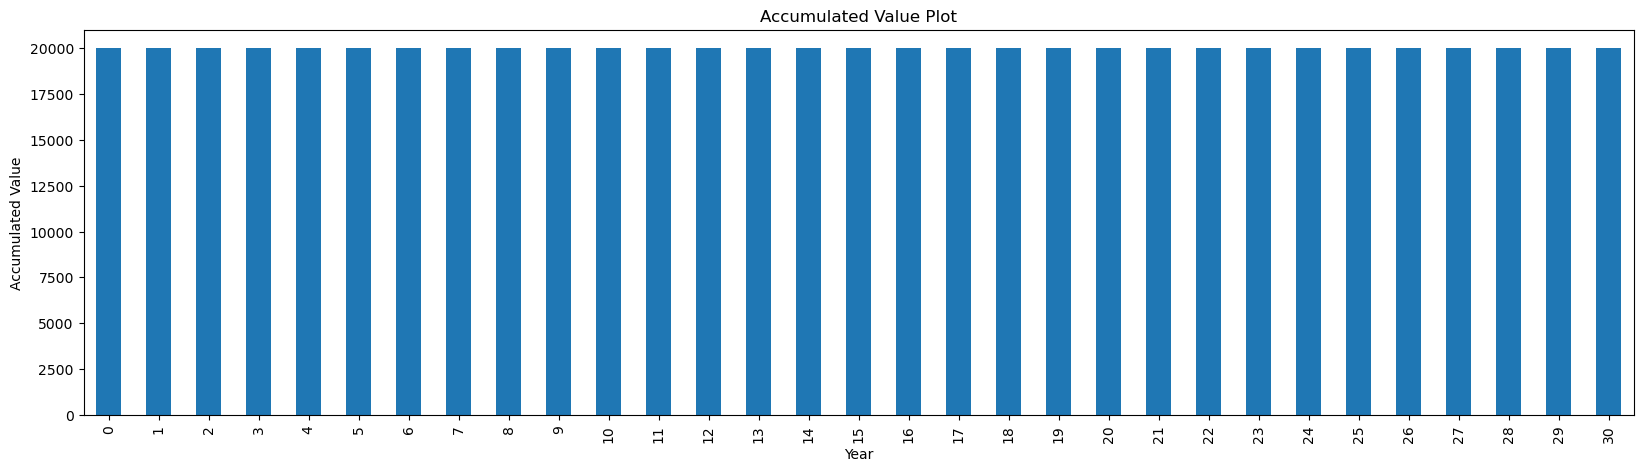

In [21]:
AV = ValueSeries.from_deposit(PERIODS, 20000)
AV.plot()

## Adding interest payments, gives exponential growth (in today's EUR)

Total value of 20000 deposit after 30 years of compound interest: 86438.8 EUR


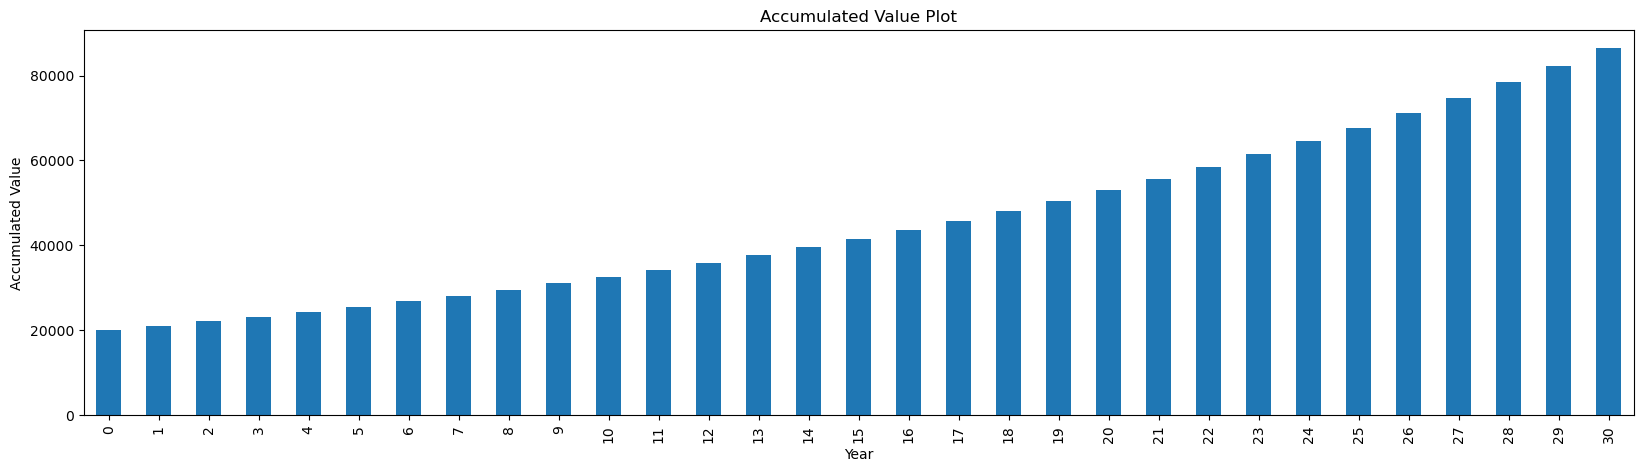

In [40]:
AV = ValueSeries.from_deposit(PERIODS, PRESENT_VALUE).with_interest(0.05)
AV.plot()
print(f"Total value of {PRESENT_VALUE} deposit after {PERIODS} years of compound interest: {AV.total():.1f} EUR")

In [41]:
%%ipytest
def test_reverse():
    # Discounting reverses the effect
    AV = ValueSeries.from_deposit(PERIODS, PRESENT_VALUE).with_interest(0.05).discount(0.05)
    assert ((AV - ValueSeries.from_deposit(PERIODS, PRESENT_VALUE)).abs() < 1e-6).all()

.                                                                                            [100%]
1 passed in 0.02s


## CashFlow generated by savings

# Comparison deposit value vs investment value

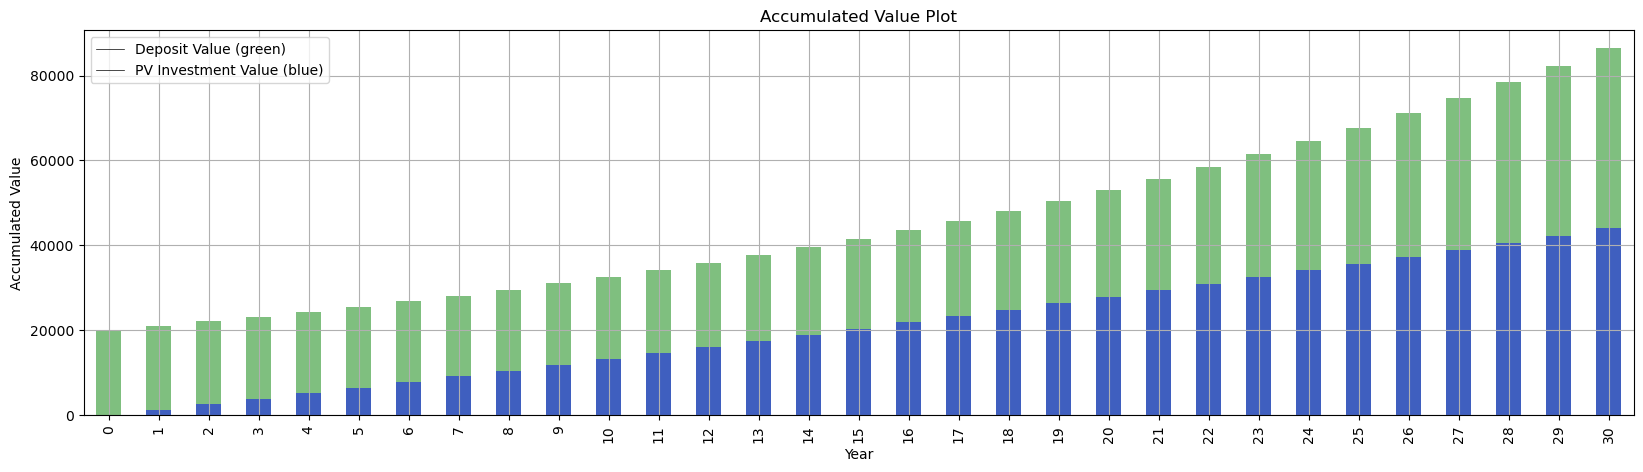

In [43]:
# Deposit 20K with with 5% invest
RAV = ValueSeries.from_deposit(PERIODS, PRESENT_VALUE).with_interest(0.05)

# Invest 20K into PV. Get Electricuity back. Assume that energy will not be subjecto to inflation, but get slightly more expensive (+1% pa)
AV = ValueSeries(ValueSeries.from_cash_flow(CashFlow.from_investment(PERIODS, PRESENT_VALUE, ANNUAL_PAYMENT).discount(-0.01)) + PRESENT_VALUE)

RAV.plot(color="green", alpha=0.5)
AV.plot(color="blue", alpha = 0.5)
plt.grid(True)
plt.legend(["Deposit Value (green)", "PV Investment Value (blue)"])

# Credit Leverage

Credits allow us trade investments today for future payments.

In [29]:
@dataclass
class Credit:
    amount : float
    years  : int
    interest : float

    def rate(self):
        return - npf.pmt(self.interest, self.years, self.amount)

    def cash_flow(self):
        cf = np.zeros(self.years + 1)
        cf[0] = self.amount
        cf[1:] = - self.rate()
        return CashFlow(cf)
    
    def costs(self):
        return self.rate() * self.years - self.amount
    
def new_credit(amount,years,interest):
    Credit(amount, years, interest)

## Cash flow generated from Credit

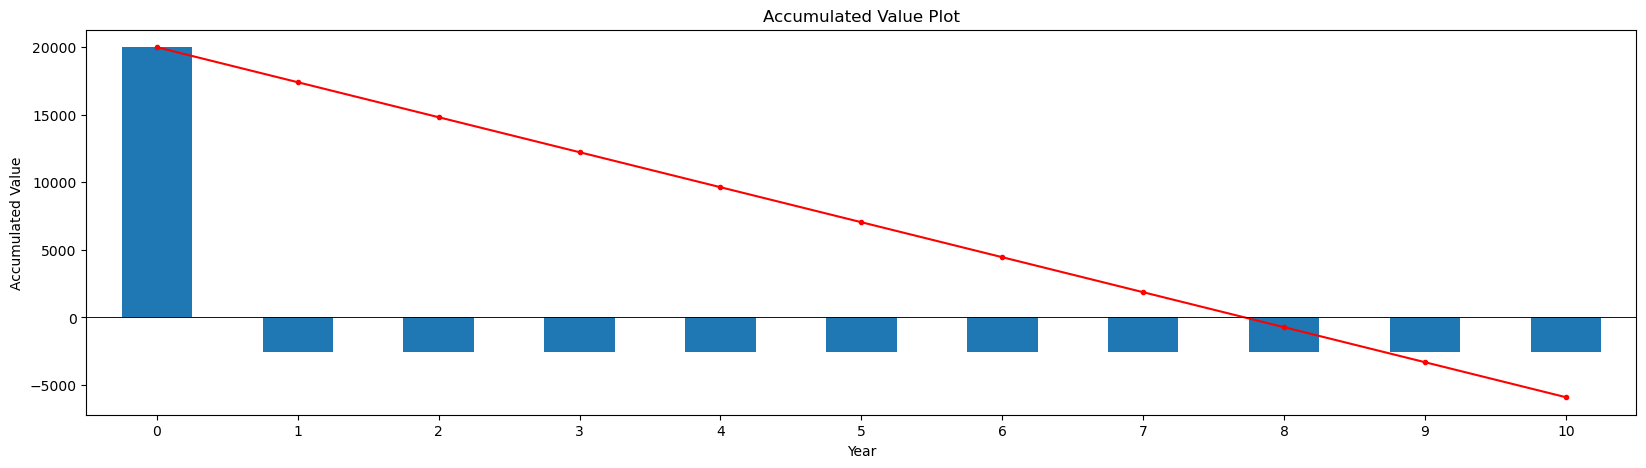

In [57]:
cf = Credit(20000, 10, 0.05).cash_flow()
cf.plot()
av = ValueSeries.from_cash_flow(cf)
av.plot(kind="line", style=".-", color="red")
P(f"Sum of cash flow {cf.sum():.2f} will be negative as we are paying interest.")

In [58]:
%%ipytest
def test_cc():
    "We can compute the total sum of credit cash flow with credit_costs"
    cf = Credit(20000, 10, 0.05).cash_flow()
    assert cf.sum() == -Credit(20000, 10, 0.05).costs()

def test_discounted_cc():
    "Summing the discounted cash-flow gives close to zero value"
    cf = Credit(20000, 10, 0.05).cash_flow().discount(0.05)
    assert cf.sum() == pytest.approx(0, abs=1e-6)

..                                                                                           [100%]
2 passed in 0.02s


## Discounted Cashflow from Credit gives Zero total value (if discounted with interest rate)

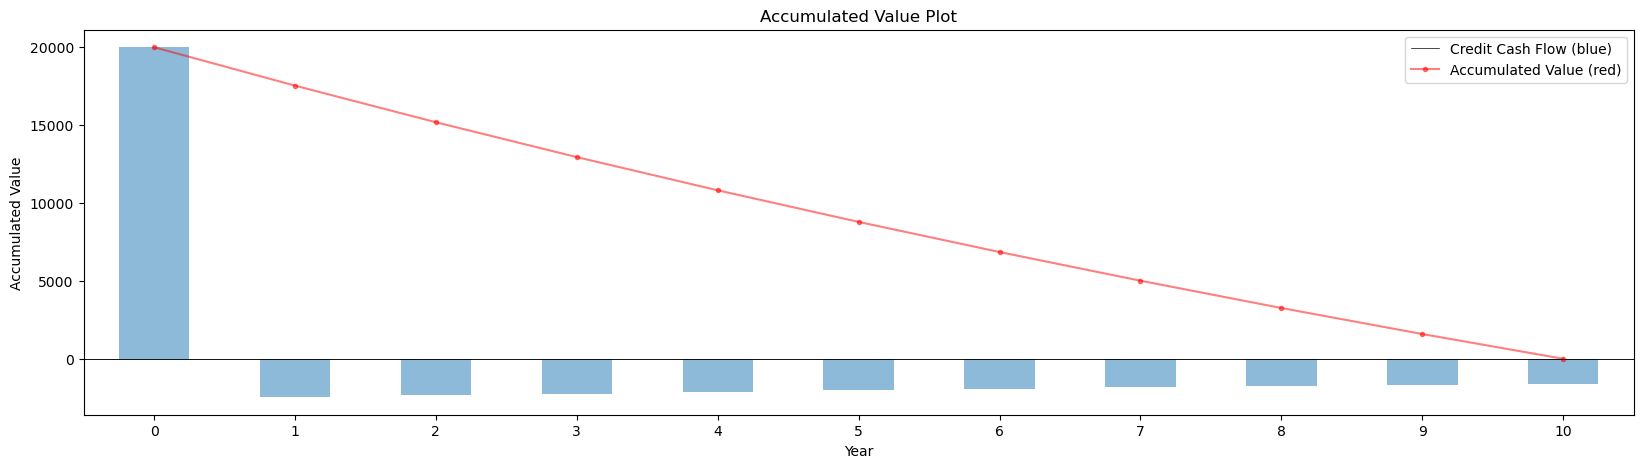

In [32]:
cf = Credit(20000, 10, 0.05).cash_flow().discount(0.05)

cf.plot(
    alpha = 0.5
)
ValueSeries.from_cash_flow(cf).plot(
    color = "red",
    alpha = 0.5,
    kind = 'line',
    style = '.-',
)
plt.legend(["Credit Cash Flow (blue)", "Accumulated Value (red)"])

## Buying stocks on Credit - Gives netural results if Stock appreciation = Credit interest

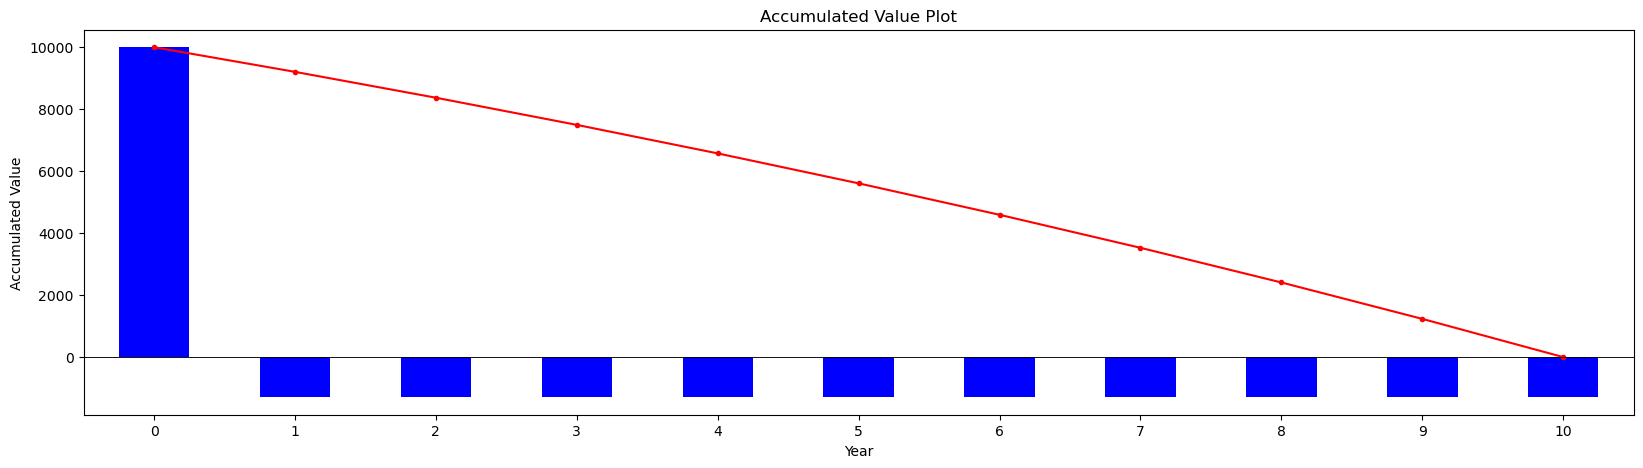

In [33]:
cf = Credit(10000, 10, 0.05).cash_flow()
av = ValueSeries.from_cash_flow(cf).with_interest(0.05)
cf.plot(color='blue')
av.plot(kind="line", style=".-", color='red')

## Adding credits, helps to avoid negative cash flow - while keeping the same NPV

Present value of original cash flow -784.436
Present value of total cash flow -784.436


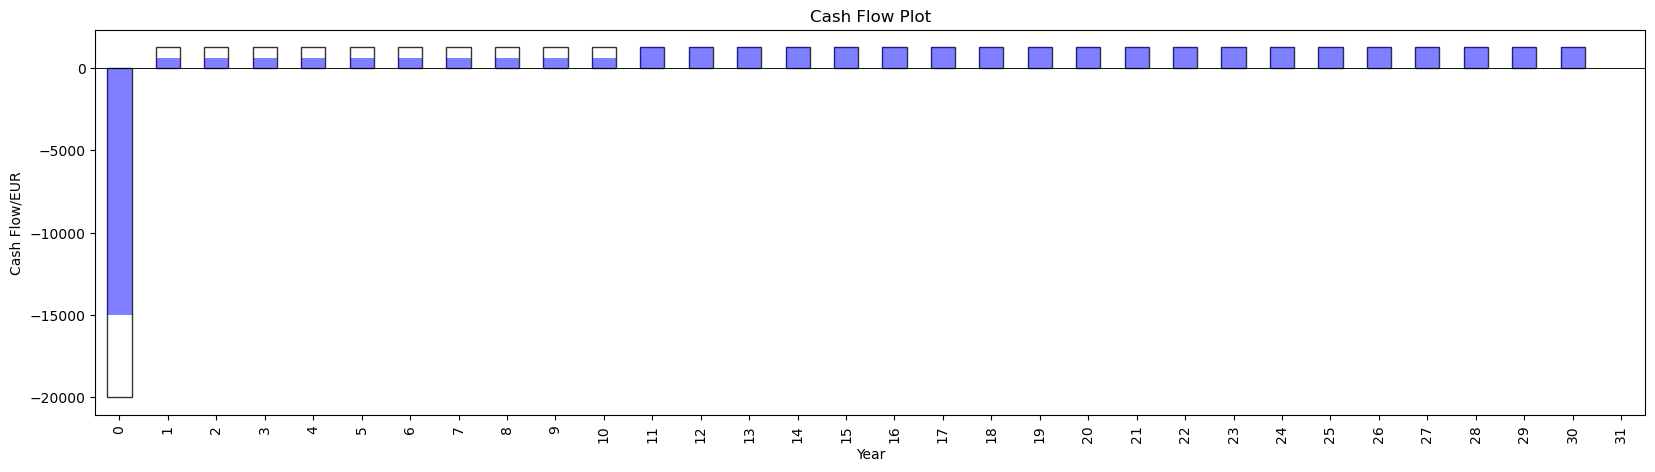

In [60]:
CF = CashFlow.from_investment(PERIODS, PRESENT_VALUE, ANNUAL_PAYMENT)
ccf = Credit(5000, 10, 0.05).cash_flow().pad(PERIODS)
tcf = CF + ccf

CF.plot(
    alpha=0.8,
    color = 'white',
    edgecolor = 'k'
)
tcf.plot(
    alpha = 0.5,
    color = 'b'
)
print(f"Present value of original cash flow {CF.present_value(0.05):.3f}")
print(f"Present value of total cash flow {tcf.present_value(0.05):.3f}")

## What's the best credit we can get without getting negative cash flow?

-1065.9018109679027
-3743.4288701362475


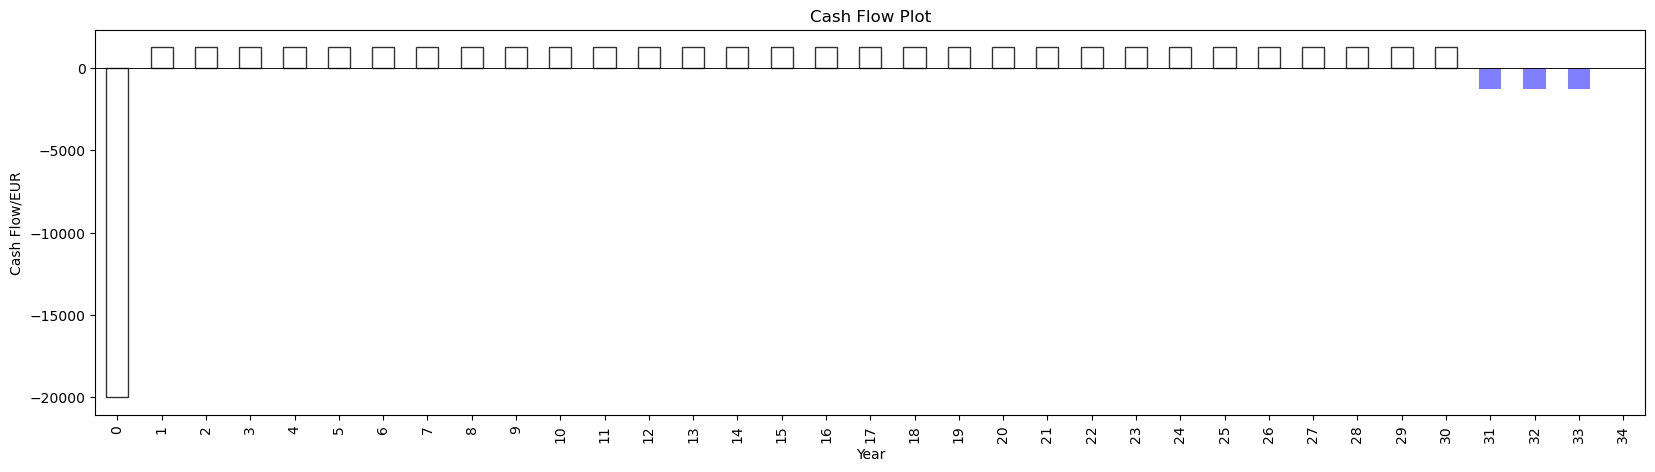

In [74]:
def credit_with_max_payment(amount, interest, max_payment, max_years = 100):
    for y in range(1, max_years):
        c = Credit(amount, y, interest)
        if c.rate() < max_payment:
            return c

# It's not possible to get a credit that pays for itself this within 30 years
CREDIT_INTEREST = 0.05
CREDIT_MAX_YEARS = 100
        
CF = CashFlow.from_investment(PERIODS, PRESENT_VALUE, ANNUAL_PAYMENT)
ccf = credit_with_max_payment(PRESENT_VALUE, CREDIT_INTEREST, ANNUAL_PAYMENT, CREDIT_MAX_YEARS).cash_flow()
tcf = CF + ccf

CF.plot(alpha=0.8, color = 'white', edgecolor = 'k')
tcf.plot(alpha = 0.5, color = 'b')

print(tcf.present_value(0.04))
print(tcf.sum())

## Investment Plan

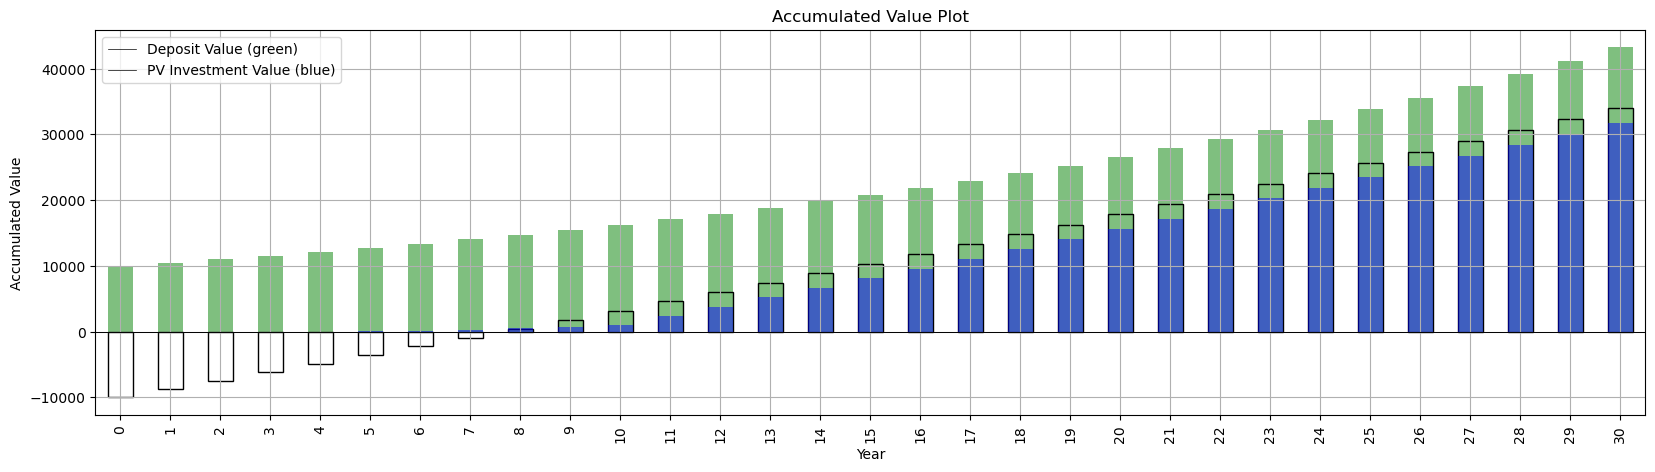

In [56]:
BUDGET = 10000 # Available budget that we want to invest
CREDIT = PRESENT_VALUE - BUDGET # The remaining costs need to be financed
CREDIT_YEARS = 10
CREDIT_INTEREST = 0.06
INFLATION = 0.02

# Option 1: Invest BUDGET with 5% earnings
RAV = ValueSeries.from_deposit(PERIODS, BUDGET).with_interest(0.05)

# Option 2: Cashflow is a composite of
# A - PV Investment - Assume that electricity increases in value by 1% after inflation adjustment
# B - Credit - Credit payments are subject to inflation
# C - Invested budget - One time payment. Not subject to inflation
A = ValueSeries.from_cash_flow(CashFlow.from_investment(PERIODS, PRESENT_VALUE, ANNUAL_PAYMENT).discount(-0.01)).to_numpy()
B = ValueSeries.from_cash_flow(Credit(CREDIT, CREDIT_YEARS, CREDIT_INTEREST).cash_flow().discount(INFLATION).pad(PERIODS)).to_numpy()
C = ValueSeries.from_deposit(PERIODS, BUDGET).to_numpy()
AV_0 = ValueSeries(A+C)
AV = ValueSeries(A+B+C)

RAV.plot(color="green", alpha=0.5)
AV_0.plot(facecolor="None", edgecolor="k", alpha=1)
AV.plot(color="blue", alpha = 0.5)

plt.grid(True)
plt.legend(["Deposit Value (green)", "PV Investment Value (blue)"])

# BACKUP

## Deposit Equivalent

How much money would I need to deposit today, to have 15.7K in 30 years?

In [44]:
def deposit_equivalent_from_future_value(periods, future_value, interest_rate):
    return future_value / (1 + interest_rate) ** periods

Depositing an amount of 4049.1053514775126 with compound interest, give the equivalent value the PV investment after 30 years


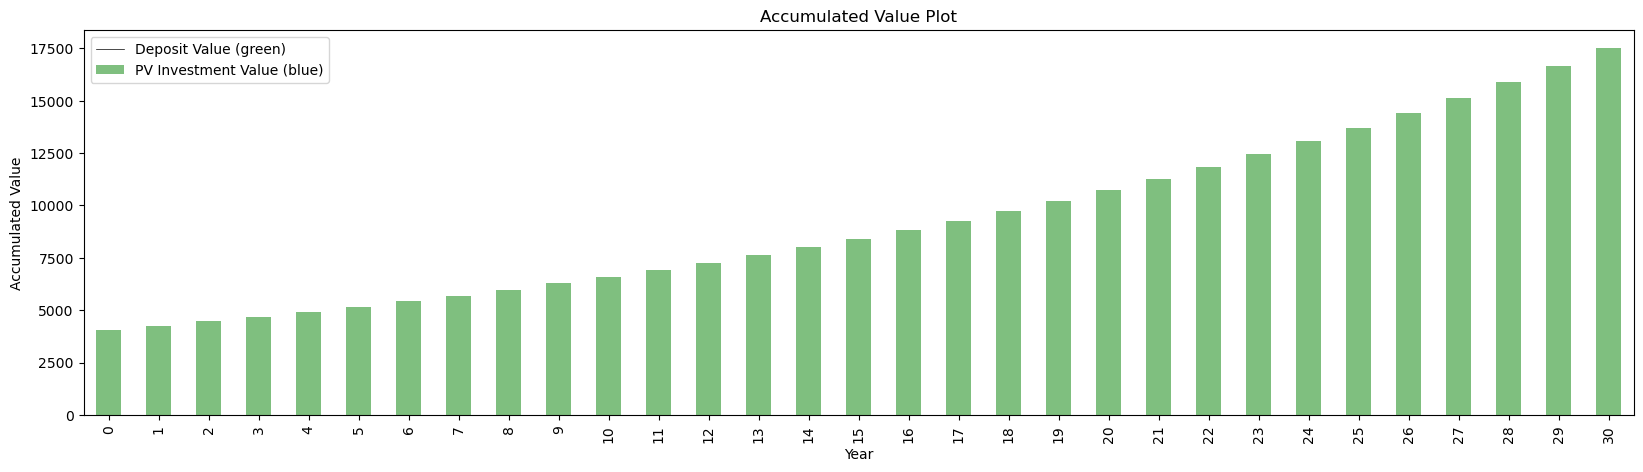

In [47]:
DEPOSIT = deposit_equivalent_from_future_value(PERIODS, N_PROFIT, 0.05)
RAV = ValueSeries.from_deposit(PERIODS, DEPOSIT).with_interest(0.05)
# AV = ValueSeries.from_cash_flow( CF )
# RAV.plot(color="green", alpha=0.5)
# AV.plot(color="blue", alpha = 1)
plt.legend(["Deposit Value (green)", "PV Investment Value (blue)"])

print(f"Depositing an amount of {DEPOSIT} with compound interest, give the equivalent value the PV investment after 30 years")